# Product Data Cleaning

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as mno
from anytree import Node, RenderTree, PreOrderIter, findall
from anytree.exporter import JsonExporter

In [19]:
# Source data: https://www.kaggle.com/datasets/promptcloud/walmart-product-data-2019/data
df = pd.read_csv("../data/marketing_sample_for_walmart_com-ecommerce__20191201_20191231__30k_data.csv")

In [20]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,description,list_price,sale_price,brand,item_number,gtin,package_size,category,postal_code,available
0,019b67ef7f01103d8fb0a53e4c36daa7,2019-12-18 10:20:52 +0000,https://www.walmart.com/ip/La-Costena-Chipotle...,"La Costena Chipotle Peppers, 7 OZ (Pack of 12)",We aim to show you accurate product informati...,31.93,31.93,La Costeï¿½ï¿½a,NaN,139941530,NaN,"Food | Meal Solutions, Grains & Pasta | Canned...",NaN,True
1,3a4ff306dcc8a6e2bf720964d29b84c3,2019-12-18 17:21:48 +0000,https://www.walmart.com/ip/Equate-Triamcinolon...,Equate Triamcinolone Acetonide Nasal Allergy S...,We aim to show you accurate product informati...,10.48,10.48,Equate,569045548.0,632775553,NaN,Health | Equate | Equate Allergy | Equate Sinu...,NaN,True
2,80090549d7d176327b186353c7b28ca4,2019-12-18 17:46:41 +0000,https://www.walmart.com/ip/AduroSmart-ERIA-Sof...,AduroSmart ERIA Soft White Smart A19 Light Bul...,We aim to show you accurate product informati...,10.99,10.99,AduroSmart ERIA,568068849.0,281487005,NaN,Electronics | Smart Home | Smart Energy and Li...,NaN,True
3,151ee1c61a29bacfedb01cd500494b2f,2019-12-18 22:14:22 +0000,https://www.walmart.com/ip/24-Classic-Adjustab...,"24"" Classic Adjustable Balloon Fender Set Chro...",We aim to show you accurate product informati...,38.59,38.59,lowrider,NaN,133714060,NaN,Sports & Outdoors | Bikes | Bike Accessories |...,NaN,True
4,7b2ef8d41f65df121f6b4b9828cf8dad,2019-12-18 06:56:02 +0000,https://www.walmart.com/ip/Elephant-Shape-Sili...,Elephant Shape Silicone Drinkware Portable Sil...,We aim to show you accurate product informati...,5.81,5.81,Anself,NaN,104042139,NaN,Baby | Feeding | Sippy Cups: Alternatives to P...,NaN,True


## Missing values

We can see that both `package_size` and `postal_code` are missing all the values, therefore we proceed to remove these columns right away. Also, `item_number` has 70% of all entries missing and since this is not a relevant field for the chatbot we proceed to remove it.

In [21]:
df.drop(["item_number", "package_size", "postal_code"], axis=1, inplace=True)

In [22]:
df.isnull().sum()

uniq_id              0
crawl_timestamp      0
product_url          0
product_name         0
description         53
list_price           0
sale_price           0
brand              564
gtin                 0
category            17
available            0
dtype: int64

<Axes: >

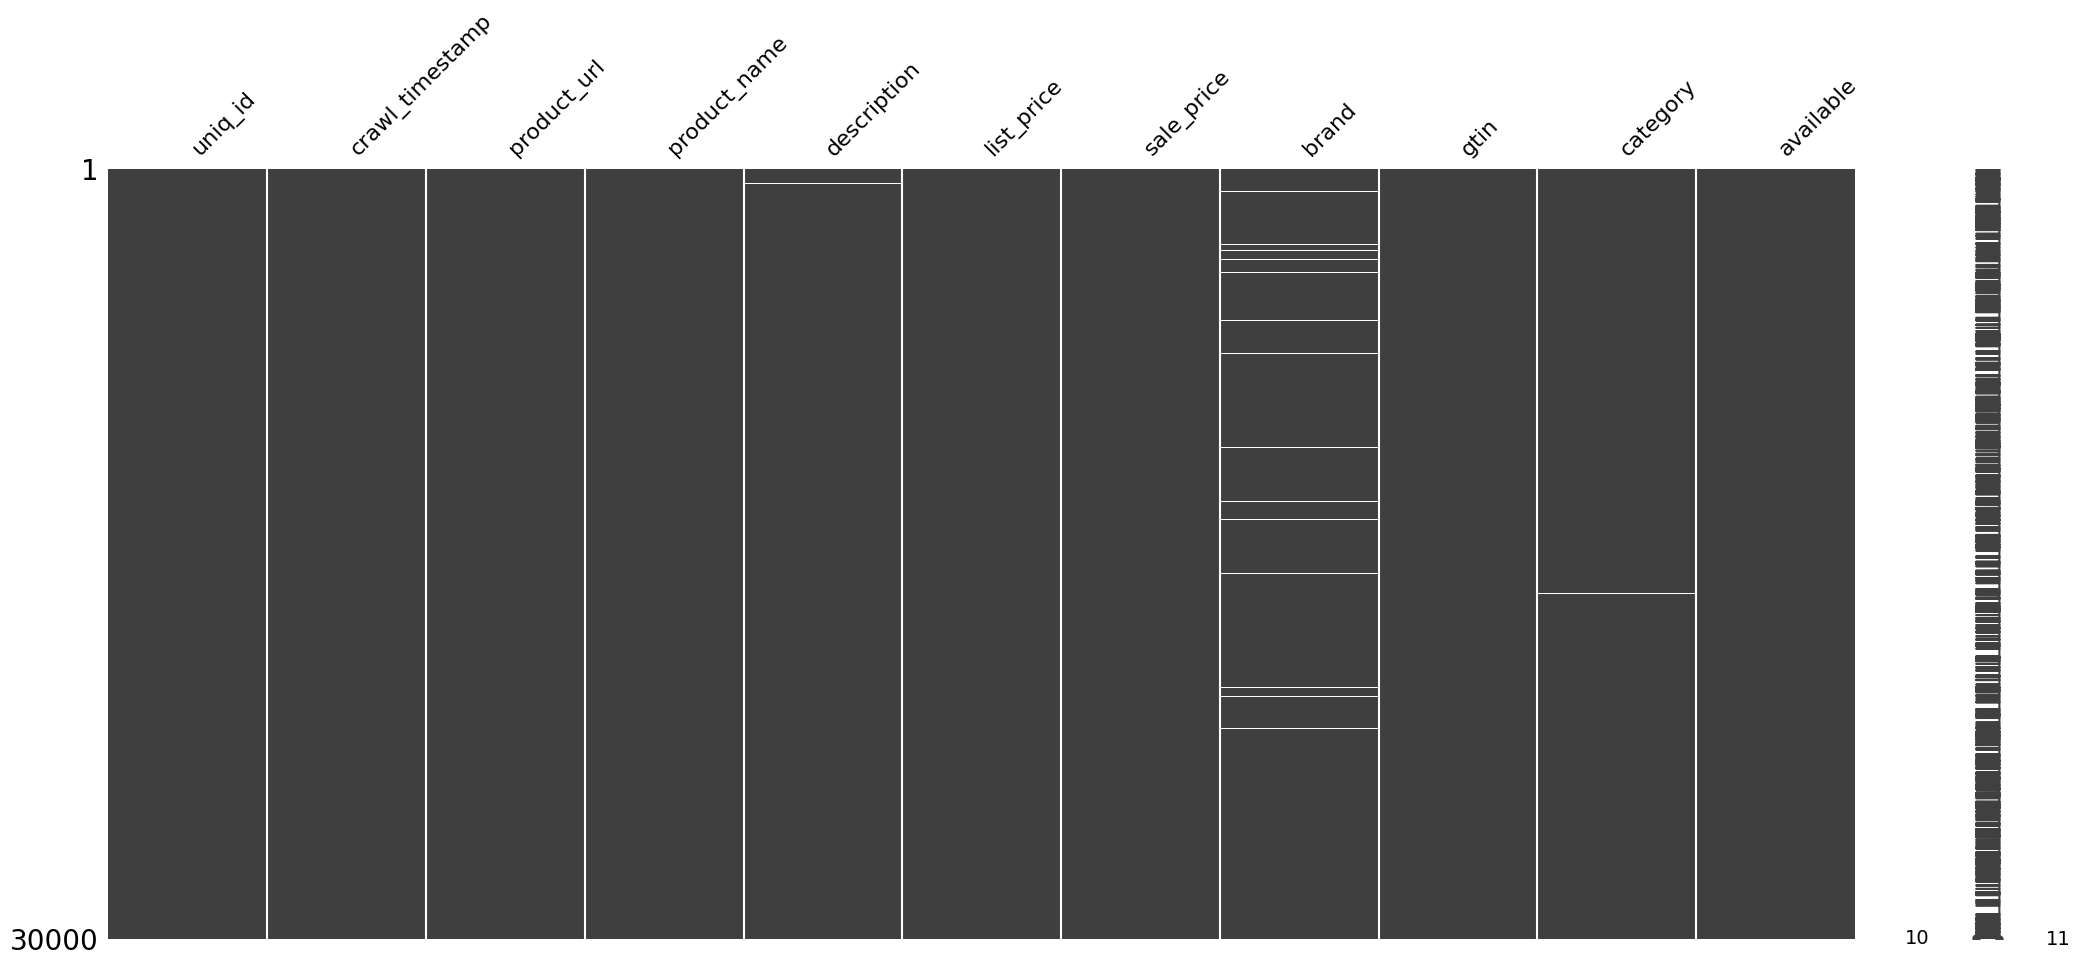

In [23]:
mno.matrix(df)

Next we replace the missing values from `brand` with a default value `<UNKNOWN>` and remove the products without description nor category, as these represent a very small portion of the data and don't provide usable information for the Chatbot.

In [24]:
df["brand"].fillna("<UNKNOWN>", inplace=True)

In [25]:
df.dropna(subset="description", inplace=True)
df.dropna(subset="category", inplace=True)

In [26]:
df.dropna(subset="category", inplace=True)

## Feature Engineering

### Description
Remove the default string from each product description: "We aim to show you accurate product information. Manufacturers, suppliers and others provide what you see here, and we have not verified it. See our disclaimer |".

In [27]:
df["description"][1]

' We aim to show you accurate product information. Manufacturers, suppliers and others provide what you see here, and we have not verified it. See our disclaimer |Compare to Nasacort Allergy 24HR active ingredient. Triamcinolone Acetonide Nasal Allergy Spray, 55 mcg per spray, allergy symptom reliever (glucocorticoid)*, is a non-drowsy, multi-symptom nasal spray for 24 hour relief of allergy symptoms such as nasal congestion, sneezing, runny and itchy nose. For adults and children ages 2 years and older. *Triamcinolone acetonide is a steroid medicine known as a glucocorticoid. Equate Multi-Symptom Nasal Allergy Spray, 60 Sprays, 0.37 fl oz: ACTIVE INGREDIENT: This multi-symptom nasal allergy spray provides 24 hour relief in adults and children ages 2 years and older. Compare to the active ingredient in Nasacort Allergy 24HR. EFFECTIVE: This nasal spray temporarily relieves symptoms of hay fever or other upper respiratory allergies: nasal congestion, runny nose, sneezing and itchy nose.

In [28]:
target_sentence = "We aim to show you accurate product information. Manufacturers, suppliers and others provide what you see here, and we have not verified it. See our disclaimer |"
df['description'].str.contains(target_sentence, regex=False).sum()

29930

In [29]:
df['description'] = df['description'].str.replace(target_sentence, '')
df['description'] = df['description'].str.strip()


In [30]:
df['description'][:6]

0    La Costena Chipotle Peppers, 7 OZ (Pack of 12)...
1    Compare to Nasacort Allergy 24HR active ingred...
2    The Soft White ERIA A19 bulb (2700K) can be co...
3    Lowrider Fender Set 24" Classic Adjustable Chr...
4    This is a kind of fine quality silicone cup li...
5    Enojy one of your favorite tea flavors with th...
Name: description, dtype: object

Numbe of empty descriptions:

In [31]:
((df['description'].isna()) | (df['description'].str.isspace()) | (df["description"] == '')).sum()

94

The histogram of description's word length shows the majority of entries having very low number of words. We need to remove the entries that don't contain enough deep information to feed the chatbot (not more than 10 words).

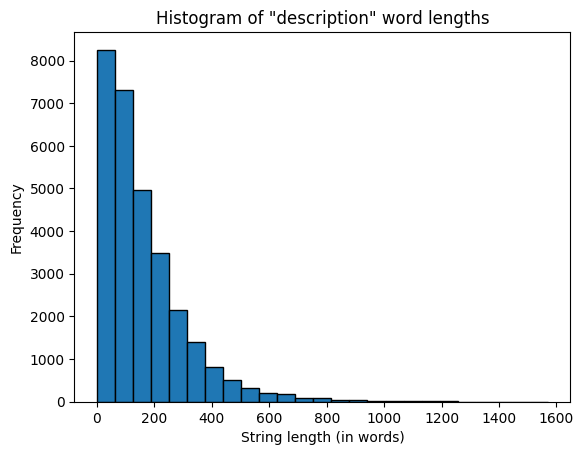

In [32]:
plt.hist(df['description'].str.split().apply(len), bins=25, edgecolor='black')
plt.xlabel('String length (in words)')
plt.ylabel('Frequency')
plt.title('Histogram of "description" word lengths')
plt.show()

In [33]:
desc_num_words = df["description"].str.split().apply(len)
MIN_WORDS_THRESHOLD = 10
low_word_entries = df[desc_num_words < MIN_WORDS_THRESHOLD]

In [34]:
low_word_entries["description"]

3        Lowrider Fender Set 24" Classic Adjustable Chr...
129      Item C26314BLUE Barcode: 91789023111 Top-Quali...
166                                                       
177                                                    new
189                                                       
                               ...                        
29951    Suncast GO3216 Golf Organizer | Fast Free Ship...
29979    Specifications Allergens: LR-54 - SKU: ZX9SSPC...
29982         Rice select arborio rice, 36 oz, (pack of 4)
29986                          450 Alloy Stem 21.1mm Blue.
29997      Gooseberries in syrup Princes Gooseberries 300g
Name: description, Length: 1190, dtype: object

In [35]:
len(low_word_entries)

1190

In [36]:
df.drop(low_word_entries.index, axis=0, inplace=True)

After removing all these entries we reset the index.

In [37]:
df.reset_index(drop=True, inplace=True)

### Categories

We extract the number of unique categories and transform the column to contain a vector of categories.

In [38]:
df['category'][0]

'Food | Meal Solutions, Grains & Pasta | Canned Goods | Canned Vegetables'

In [39]:
df['category'] = df['category'].str.split('|').apply(lambda x: [category.strip() for category in x])

In [40]:
df['category']

0        [Food, Meal Solutions, Grains & Pasta, Canned ...
1        [Health, Equate, Equate Allergy, Equate Sinus ...
2        [Electronics, Smart Home, Smart Energy and Lig...
3        [Baby, Feeding, Sippy Cups: Alternatives to Pl...
4                          [Food, Beverages, Tea, All Tea]
                               ...                        
28735    [Food, Snacks, Cookies & Chips, Chips & Crisps...
28736              [Food, Frozen Foods, Frozen Vegetables]
28737    [Sports & Outdoors, Bikes, Bike Components, Bi...
28738    [Beauty, Hair Care, Hair Styling Tools, Flat I...
28739    [Beauty, Here for Every Beauty, Featured Shops...
Name: category, Length: 28740, dtype: object

In [41]:
root = Node('Products')

def add_node(parent, child):
    """Add nodes to the tree."""
    existing_node = findall(parent, filter_=lambda node: node.name == child)
    if existing_node:
        return existing_node[0]
    else:
        return Node(child, parent=parent)

for index, row in df.iterrows():
    current_parent = root
    
    for category in row["category"]:
        current_parent = add_node(current_parent, category)

In [42]:
for pre, fill, node in RenderTree(root, maxlevel=2):
    print(f"{pre}{node.name}")

Products
├── Food
├── Health
├── Electronics
├── Baby
├── Home
├── Household Essentials
├── Sports & Outdoors
├── Clothing
├── Personal Care
├── Toys
├── Beauty
├── Shop by Brand
├── Home Improvement
├── Industrial & Scientific
├── Patio & Garden
├── Pets
├── Auto & Tires
├── Party & Occasions
├── Seasonal
├── Feature
├── Books
├── Video Games
├── Office Supplies
├── Collectibles
├── Jewelry
├── Cell Phones
├── Walmart for Business
├── Musical Instruments
├── Arts Crafts & Sewing
├── Shop by Movie
└── Music


In [43]:
# Top main categories
len(root.children)

31

In [44]:
# Traverse the tree to count all nodes
sum(1 for _ in PreOrderIter(root, maxlevel = None))

4380

In [45]:
# Max depth in the tree
max_depth = 0
for _node in PreOrderIter(root, maxlevel = None):
    if _node.depth > max_depth: max_depth = _node.depth

max_depth

9

Export the tree for later use:

In [46]:
exporter = JsonExporter(indent=2, sort_keys=True)
tree = exporter.export(root)

# Save the JSON data to a file
with open("../data/tree_categories.json", 'w') as json_file:
    json_file.write(tree)

### Remove unnecessary data

We start by removing the `crawl_timestamp` as this information is outside the product domain.

In [47]:
df.drop("crawl_timestamp", axis=1, inplace=True)

In [48]:
df.head()

,uniq_id,product_url,product_name,description,list_price,sale_price,brand,gtin,category,available
0,019b67ef7f01103d8fb0a53e4c36daa7,https://www.walmart.com/ip/La-Costena-Chipotle...,"La Costena Chipotle Peppers, 7 OZ (Pack of 12)","La Costena Chipotle Peppers, 7 OZ (Pack of 12)...",31.93,31.93,La Costeï¿½ï¿½a,139941530,"[Food, Meal Solutions, Grains & Pasta, Canned ...",True
1,3a4ff306dcc8a6e2bf720964d29b84c3,https://www.walmart.com/ip/Equate-Triamcinolon...,Equate Triamcinolone Acetonide Nasal Allergy S...,Compare to Nasacort Allergy 24HR active ingred...,10.48,10.48,Equate,632775553,"[Health, Equate, Equate Allergy, Equate Sinus ...",True
2,80090549d7d176327b186353c7b28ca4,https://www.walmart.com/ip/AduroSmart-ERIA-Sof...,AduroSmart ERIA Soft White Smart A19 Light Bul...,The Soft White ERIA A19 bulb (2700K) can be co...,10.99,10.99,AduroSmart ERIA,281487005,"[Electronics, Smart Home, Smart Energy and Lig...",True
3,7b2ef8d41f65df121f6b4b9828cf8dad,https://www.walmart.com/ip/Elephant-Shape-Sili...,Elephant Shape Silicone Drinkware Portable Sil...,This is a kind of fine quality silicone cup li...,5.81,5.81,Anself,104042139,"[Baby, Feeding, Sippy Cups: Alternatives to Pl...",True
4,e4fab4b6f41eac02d22b421818c8f080,https://www.walmart.com/ip/6-Boxes-Twinings-of...,(6 Boxes) Twinings of London Nightly Calm Gree...,Enojy one of your favorite tea flavors with th...,17.99,17.99,Twinings,55450414,"[Food, Beverages, Tea, All Tea]",False


We can see that there are enough relevant differences between `list_price` and `sale_price`, therefore we maintain both columns. We create a column named `discount` that indicates when the sele price is lower than list price.

In [49]:
print("Number of products with different prices:", (df['list_price'] != df['sale_price']).sum())
print("Number of products with lower sale price:", (df['list_price'] > df['sale_price']).sum())

Number of products with different prices: 1527
Number of products with lower sale price: 1525


In [50]:
df["discount"] = (df['list_price'] > df['sale_price'])

In [51]:
df.head()

,uniq_id,product_url,product_name,description,list_price,sale_price,brand,gtin,category,available,discount
0,019b67ef7f01103d8fb0a53e4c36daa7,https://www.walmart.com/ip/La-Costena-Chipotle...,"La Costena Chipotle Peppers, 7 OZ (Pack of 12)","La Costena Chipotle Peppers, 7 OZ (Pack of 12)...",31.93,31.93,La Costeï¿½ï¿½a,139941530,"[Food, Meal Solutions, Grains & Pasta, Canned ...",True,False
1,3a4ff306dcc8a6e2bf720964d29b84c3,https://www.walmart.com/ip/Equate-Triamcinolon...,Equate Triamcinolone Acetonide Nasal Allergy S...,Compare to Nasacort Allergy 24HR active ingred...,10.48,10.48,Equate,632775553,"[Health, Equate, Equate Allergy, Equate Sinus ...",True,False
2,80090549d7d176327b186353c7b28ca4,https://www.walmart.com/ip/AduroSmart-ERIA-Sof...,AduroSmart ERIA Soft White Smart A19 Light Bul...,The Soft White ERIA A19 bulb (2700K) can be co...,10.99,10.99,AduroSmart ERIA,281487005,"[Electronics, Smart Home, Smart Energy and Lig...",True,False
3,7b2ef8d41f65df121f6b4b9828cf8dad,https://www.walmart.com/ip/Elephant-Shape-Sili...,Elephant Shape Silicone Drinkware Portable Sil...,This is a kind of fine quality silicone cup li...,5.81,5.81,Anself,104042139,"[Baby, Feeding, Sippy Cups: Alternatives to Pl...",True,False
4,e4fab4b6f41eac02d22b421818c8f080,https://www.walmart.com/ip/6-Boxes-Twinings-of...,(6 Boxes) Twinings of London Nightly Calm Gree...,Enojy one of your favorite tea flavors with th...,17.99,17.99,Twinings,55450414,"[Food, Beverages, Tea, All Tea]",False,False


### Encoding problems

After manual inspection, we manually resolve some of the encoding issues:

In [70]:
df['brand'] = df['brand'].str.replace('ï¿½ï¿½', 'ñ')
df['product_name'] = df['product_name'].str.replace('ï¿½', 'e')
df['description'] = df['description'].str.replace('ï¿½', '')
df['description'] = df['description'].str.replace('ï_Œ', '-')

## Export CSV

In [71]:
df.to_csv("../data/products.csv", index=False)